## Imports & preparation

In [1]:
import scipy
import numpy as np
import pandas as pd
import paths

# Import the Generator class
from bioverse.generator import Generator
from bioverse.survey import TransitSurvey
from bioverse.constants import CONST, DATA_DIR
# from bioverse import util

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
# %matplotlib osx
# %matplotlib inline

import plotstyle
plotstyle.styleplots()


%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 200
pd.options.display.max_columns = 80

figdir = '/Users/schlecker/repos/magmaocean/src/tex/figures/'
talkfigdir = '/Users/schlecker/talks/20221107_HabitableWorlds_Bioverse/figures/' 

## preparatory steps (to be done only once)

Read in Dorn & Lichtenberg 2021 Fig. 3b from plot line extractor

In [2]:
# from scipy.interpolate import interp1d
# from bioverse.constants import DATA_DIR

# wrr_grid = np.geomspace(1e-4, 3e-1, num=20)
# xy = {'wrr' : wrr_grid}

# for i, (mp, mp_flt) in enumerate(zip(['0p3', '0p8', '2p4', '6p7'], [0.3, 0.8, 2.4, 6.7])):
#     # read extracted csv file (from plot extraction tool)
#     df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b_extracted.csv', usecols=[2*i,2*i+1])
#     f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
#     xy[mp_flt] = f_xy(wrr_grid)
    
#     plt.plot(xy['wrr'], xy[mp_flt])
# plt.xscale('log')
# plt.xlabel('water mass fraction')
# plt.ylabel('Radius deviation')

# # pd.DataFrame(xy).to_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', index=False)

In [3]:
# # sanity-check the interpolation
# df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', )

# mass_grid = np.arange(0.3, 7., 0.1)

# for wrr in wrr_grid[::3]:
#     dr_wrr = df.iloc[(df['wrr'] - wrr).abs().argsort()[0], :][1:]
#     f_dr = interp1d(dr_wrr.index.to_numpy(dtype=float), dr_wrr.values, fill_value='extrapolate')
#     dr = f_dr(mass_grid)
#     plt.plot(mass_grid, dr, label = '{:.0e}'.format(wrr))

# # for i, mp_flt in enumerate([0.3, 0.8, 2.4, 6.7]):
#     # f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
#     # xy[mp_flt] = f_xy(wrr_grid)
#     # plt.plot(df['wrr'], df[str(mp_flt)])
    
# # plt.xscale('log')

# plt.xlabel('planet mass')
# plt.ylabel('Radius deviation')
# plt.legend(fontsize=12, loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
 

# Sample generation

## Generate stars and planets, inject magma oceans


Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.

Set a generic detection bias: transit depth $\delta > 75$ ppm.

In [4]:
# Parameters of the analysis
# parameter_of_interest = 'rho'
parameter_of_interest = 'R'


def get_generator_args():
    # Parameters for star generation 
    stars_args = {
    # 'd_max' : 90,             # max. distance to stars in parsec
    'd_max' : 40,             # max. distance to stars in parsec
    'M_st_max' : 1.5,         # Maximum stellar mass to consider, in solar units.
    'M_G_max' : 11,           # Maximum gaia magnitude of stars
    'seed' : 42,              # seed for random number generators
    'lum_evo' : False         # luminosities from luminosity tracks (Baraffe et al. 1998), based on random ages? [SLOW?]
    } 

    # Parameters for planet generation and magma ocean model
    planets_args = {
    'transit_mode': True,      # Simulate only transiting planets
    'f_eta' : 1.,               # Occurrence rate scaling factor
    'R_min' : 0.75,             # minimum radius for Bergsten et al. planet generator
    'P_max' : 365.,             # maximum period for Bergsten et al. planet generator

    'mr_relation' : 'Zeng2016', # choice of mass-radius relationship

    # 'f_magma' : .9,           # baseline fraction of planets with a magma ocean _within_ the magma ocean-relevant orbital distance
    'gh_increase' : True,       # wether or not to consider radius increase due to runaway greenhouse effect (Turbet+2020)
    'water_incorp' : True,      # wether or not to consider water incorporation in the melt of global magma oceans (Dorn & Lichtenberg 2021)
    'S_thresh' : 280.,          # threshold instellation for runaway greenhouse phase
    # 'wrr' : 0.001,              # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
    'wrr' : 0.005,              # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
        
    'simplified' : False,       # increase the radii of all runaway greenhouse planets by the same fraction
    # 'diff_frac' : 0.48,       # fractional radius change in the simplified case.

    # detection bias and sample selection: Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.
    # Set a generic detection bias: transit depth $\delta > 75$ ppm.
    'M_min' : 0.1,
    'M_max' : 2.,
    'S_max' : 2000.,            # max. instellation in W/m2
    'depth_min' : 75e-6         # min. transit depth
    }

    return stars_args, planets_args


stars_args, planets_args = get_generator_args()

g_transit = Generator(label=None)
g_transit.insert_step('read_stars_Gaia') 

# provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in stars_args.items()]

# Insert a function to the generator that labels late M dwarfs, defining a stellar mass threshold Mst_threshold.
# g_transit.insert_step(label_lateM)

# the stellar sample alone can be extracted here:
stars = g_transit.generate() 
# stars.to_pandas().M_st.hist()
# plt.xlabel('M_star')

# Generate planets
g_transit.insert_step('create_planets_bergsten')
g_transit.insert_step('assign_orbital_elements')
g_transit.insert_step('impact_parameter')
g_transit.insert_step('assign_mass')
g_transit.insert_step('effective_values')
g_transit.insert_step('magma_ocean')     # here we inject the magma oceans
g_transit.insert_step('compute_transit_params')
g_transit.insert_step('apply_bias')

# provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in planets_args.items()]

# save the generator
# g_transit.save('transit_magmaocean')

# show generator steps
g_transit

Created a new Generator


Generator with 9 steps:
 0: Function 'read_stars_Gaia' with 12 keyword arguments.
 1: Function 'create_planets_bergsten' with 7 keyword arguments.
 2: Function 'assign_orbital_elements' with 2 keyword arguments.
 3: Function 'impact_parameter' with 1 keyword arguments.
 4: Function 'assign_mass' with 1 keyword arguments.
 5: Function 'effective_values' with no keyword arguments.
 6: Function 'magma_ocean' with 6 keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.
 8: Function 'apply_bias' with 5 keyword arguments.

In [5]:
%%time

# use this Generator object to produce an ensemble of planets within X parsecs:

sample = g_transit.generate()
# sample = sample.to_pandas()
# print("Generated a sample of {:d} planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))
print('Total number of planets: {}'.format(len(sample)))

Total number of planets: 43
CPU times: user 6.15 s, sys: 360 ms, total: 6.51 s
Wall time: 6.57 s


## Test Bergsten et al. occurrence rates implementation

In [6]:
# # show sample in period-radius:
# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# early = sampledf[sampledf.M_st > 0.9].sample(500)
# late = sampledf[sampledf.M_st < 0.2].sample(500)

# fig, ax = plt.subplots(figsize=[10, 6])
# for sampledf, label in zip([early, late], ['early', 'late']):

#     ax.scatter(sampledf[sampledf.transiting==False].a_eff, sampledf[sampledf.transiting==False][yvar], s=5., alpha=.7, label=label)

#     # transiting planets
#     # ax.scatter(sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

#     # show differences in radius due to magma ocean
#     if yvar =='R':
#         X_coords= np.array([sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True].a_eff])
#         Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#         ax.plot(X_coords, Y_coords, c='k', lw=1., alpha=.4, zorder=-1)

#         ax.set_ylabel('Radius [$R_\oplus$]')
#     elif yvar == 'rho':
#         ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]')

#     # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#     ax.set_xlabel('Solar-equivalent semimajor axis [au]')
#     # ax.loglog()
#     ax.set_xscale('log')
#     ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                                   frameon=False, columnspacing=1.6)
#     # ax.set_ylim(0.5, 1.3)

#     print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

Plot different radii

avg radius change of runaway GH planets: +15 %
avg density change of runaway GH planets: -34 %


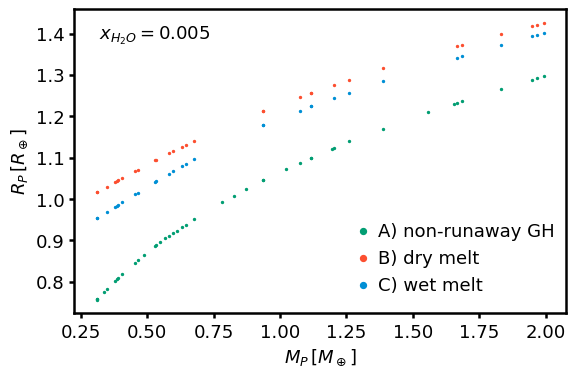

In [7]:
# check if M-R relation looks good:
dd = sample.to_pandas()
d = dd.sample(min([len(dd), 4000]))
mo = dd[dd.has_magmaocean].sample(min([len(dd[dd.has_magmaocean]), 4000]))

fig, ax = plt.subplots()
# plt.scatter(mo.M, mo.R_orig, s=1., label='original radius', c='gray')
# plt.scatter(mo.M, mo.R, s=1., label='new radius')
# plt.scatter(mo.M, mo.R - mo.R_orig, s=1., label='$\Delta R$', alpha=.4)

ax.scatter(d.M, d.R_orig, s=2., label='A) non-runaway GH', c='C0')
try:
    ax.scatter(mo.M, mo.R_steam, s=2., label='B) dry melt', c='C1')
except AttributeError:
    pass
ax.scatter(mo.M, mo.R, s=2., label='C) wet melt', c='C2')

ax.set_xlabel('$M_P \,[M_\oplus]$')
ax.set_ylabel('$R_P \,[R_\oplus]$')
ax.legend(loc='lower right', ncol=1, bbox_to_anchor=(1.01, 0.01),
                              frameon=False, columnspacing=1.6, markerscale=3)
ax.annotate('$x_{{H_2O}}= ${}'.format(planets_args['wrr']), xy=(0.05,.9), xycoords='axes fraction')

radius_change = np.average(mo.R/mo.R_orig) - 1
print('avg radius change of runaway GH planets: {:+.0f} %'.format(100*radius_change))
density_change = np.average(mo.rho/(CONST['rho_Earth']*mo.M/mo.R_orig**3)) - 1
print('avg density change of runaway GH planets: {:+.0f} %'.format(100*density_change))

In [8]:
# fig.savefig(figdir + 'radiuscomparison.pdf')

In [9]:
# # show sample in period-radius:

# from matplotlib.ticker import ScalarFormatter


# talk = False 
# if talk:
#     plt.style.use('dark_background')
# else:
#     plt.style.use('default')

# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# # fig, ax = plt.subplots(figsize=[10, 6])
# fig, ax = plt.subplots()
# ax.scatter(sampledf[sampledf.transiting==False].S_abs, sampledf[sampledf.transiting==False][yvar], s=1.5, c='dimgray',alpha=.5, label='synthetic planets')

# sampledf[sampledf.transiting==False].rho

# # transiting planets
# ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# # show differences in radius due to magma ocean
# if yvar =='R':
#     X_coords= np.array([sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True].S_abs])
#     Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#     ax.plot(X_coords, Y_coords, c='gray', lw=1.5, alpha=.5, zorder=-1)
    
#     for i in range(len(sampledf[sampledf.transiting==True])):
#         if Y_coords[1][i] != Y_coords[0][i]:
#             ax.annotate(
#               "",
#               xy=(X_coords[0][i], Y_coords[1][i]), xytext=(0, -1.),#xytext=(0., Y_coords[1][i]),
#               textcoords='offset points', ha='right', va='bottom',
#               bbox=dict(boxstyle='round,pad=0.5',  alpha=0.5),
#               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=.5, lw=1.5),
#             zorder = -9
#            )
    
#     ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# # ax.set_xlabel('Solar-equivalent semimajor axis [au]')
# ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# # ax.loglog()
# ax.set_xscale('log')
# ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
# plt.xlim(50., 2000.) 
# plt.ylim(1., 1.4)

# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

In [10]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/synthetic_population.pdf', bbox_inches='tight')
# fig.savefig(talkfigdir + 'instellation-radius_N32.png', bbox_inches='tight', dpi=600)

Same plot with only transiting planets

In [11]:
# talk = False 
# if talk:
#     plt.style.use('dark_background')

# yvar = parameter_of_interest
# sampledf = sample.to_pandas()

# # fig, ax = plt.subplots(figsize=[10, 6])
# fig, ax = plt.subplots()
# ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# if yvar =='R':
#     ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# # ax.set_xlabel('Solar-equivalent semimajor axis [au]')
# ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# # ax.loglog()
# ax.set_xscale('log')
# ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
# plt.xlim(50., 2000.) 
# plt.ylim(1., 1.4)

# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

In [12]:
# fig.savefig(talkfigdir + 'instellation-radius_transiting.png', bbox_inches='tight', dpi=600)
# fig.savefig(talkfigdir + 'instellation-radius_N500.png', bbox_inches='tight', dpi=600)

## Explore radius-sma dependency
Let's have a look at the (effective) sma dependence of planets bearing magma oceans. Hypothesis tests are based on the average planet radius *outside* the threshold instellation S_thresh.

In [13]:
# from bioverse.hypothesis import magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 
# from bioverse.util import S2a_eff, a_eff2S
# from matplotlib.ticker import ScalarFormatter
# import scipy

# talk = False
# if talk:
#     plt.style.use('dark_background')

def binned_stats(df, x_param, y_param, bins, statistic='mean'):
    means, edges, n = scipy.stats.binned_statistic(df[x_param], df[y_param], 
                                             statistic=statistic, bins=bins)
    std = []
    for e_lo, e_hi in zip(edges[:-1], edges[1:]):
        std.append(np.std(df[(df[x_param] > e_lo) & (df[x_param] < e_hi)][y_param]))
    return means, edges, n, std

# # a_eff_grid = np.geomspace(0.05, 10., num=250)         # a_eff grid
# S_grid = np.linspace(50., 2000., 250)
# a_eff_grid = S2a_eff(S_grid)




# R_avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
# R_avg_in = np.average(sample['R'][sample['S_abs'] >= planets_args['S_thresh'] & sample['transiting']])

# rho_avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                         # (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
# rho_avg_in = np.average(CONST['rho_Earth']*sample['M'][sample['S_abs'] >= planets_args['S_thresh'] & sample['transiting']]/
                         # (sample['R'][sample['S_abs'] >= planets_args['S_thresh']& sample['transiting']])**3)


# P_magma = magma_ocean_hypo_step((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['radius_reduction'], R_avg), a_eff_grid)
# P_magma = magma_ocean_hypo_exp((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['lambda_a']), a_eff_grid)
    
# avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() # import avg_deltaR_deltaRho once here to avoid a lot of file I/O during hypothesis calls
# if parameter_of_interest == 'R':
#     P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], R_avg_out), a_eff_grid, 
#                                gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
#                                simplified=planets_args['simplified'], diff_frac=radius_change,
#                                parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    
    
#     P0 = magma_ocean_f0(R_avg_out, a_eff_grid)
# elif parameter_of_interest == 'rho':
#     P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], rho_avg_out), a_eff_grid, diff_frac=density_change,
#                                parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
#     P0 = magma_ocean_f0(rho_avg_out, a_eff_grid)

# # backtransform from a_eff to S
# S_grid = a_eff2S(a_eff_grid)

# plt.plot(S_grid, P_magma, label='H$_\mathrm{magma ocean}$', lw=3)
# plt.plot(S_grid, P0, label='H$_0$')
# plt.xscale('log')

# # plt.xlabel('Solar-equivalent semimajor axis [au]',fontsize=15)
# plt.xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)

# if parameter_of_interest == 'R':
#     if talk:
#         plt.ylabel('avg. planet radius [R$_\oplus$]',fontsize=15)
#     else:
#         plt.ylabel('$<R_P>$',fontsize=15)
# elif parameter_of_interest == 'rho':
#     plt.ylabel('$<\\rho>$',fontsize=15)

# fig = plt.gcf()
# ax = plt.gca()
# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
    


N_transiting: 43


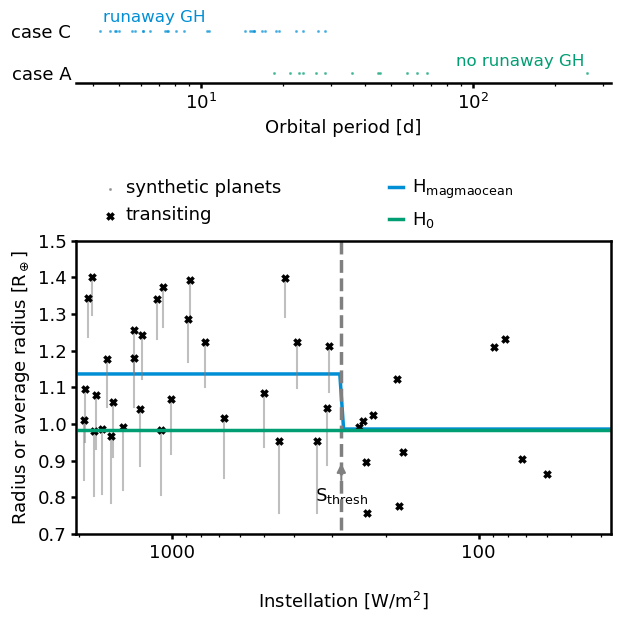

In [14]:
from HnullHmo import plot_HnullHmo, plot_transitingplanets, draw_Sthresh, plot_has_magmaocean

fig, (ax, ax2) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1,4]}, figsize=[6.4,6.4])
ax = plot_has_magmaocean(sample.to_pandas().sample(min(500, len(sample)), random_state=42), ax)
ax2 = draw_Sthresh(ax2, planets_args)
ax2 = plot_transitingplanets(sample, planets_args, ax2, parameter_of_interest='R')
# from matplotlib import rc
# rc('axes', linewidth=8)
# import plotstyle
ax2 = plot_HnullHmo(sample, planets_args, ax2, parameter_of_interest='R')


# ax2.set_xlim(2050, 37)
ax2.set_ylim(0.7, 1.5)

#DEBUG
# plt.scatter(100, np.average(s[~s.has_magmaocean].R)) 
# plt.scatter(1000, np.average(s[s.has_magmaocean].R)) 


fig.tight_layout(h_pad=2.)


print('N_transiting: {}'.format(sample.to_pandas().transiting.sum()))

In [15]:
# fig.savefig(paths.static / "HnullHmo.pdf")

plot Phi(k) correlation between planets having a magma ocean and planets smaller than the mean of the populatio

In [16]:
# import phik
# from phik import resources, report

# sample.to_pandas()[['is_small', 'has_magmaocean']].hist2d()
# sample.to_pandas()[['is_small', 'has_magmaocean']].phik_matrix()

# Compute radius differences to inform hypotheses

The magma ocean hypotheses rely on measurements of average radii and bulk densities. Here, we create a table to inform the hypothesis function.

We take into account *only the transiting planets*, as these are the ones we'll be detecting (the radius differences of transiting planets differ on the percent level compared to using all planets).

-------
**This needs to be executed whenever:**
- file `avg_deltaR_deltaRho.csv` is not available
- stars or planets are generated from a different source (e.g. different occurrence rates)
- new biases/sample limits are introduced (e.g. minimum planet radius, transit depth, ...)

-------

This is slow (~8min if considering stellar evo).

In [17]:
# %%time
# from bioverse.hypothesis import compute_avg_deltaR_deltaRho
# avg_deltaR_deltaRho = compute_avg_deltaR_deltaRho(stars_args, planets_args)

# # reset star, planet args for use in this notebook
# stars_args, planets_args = get_generator_args()

# Survey simulation

We have generated a population of synthetic planets that orbit synthetic stars and we have injected a statistical trend originating from the presence of magma oceans on some planets. Only a subset of these planets "will be detectable by a transit or direct imaging survey. For those planets, only a subset of their properties can be directly probed, and only with a finite level of precision."

In the following, we will simulate a transit survey and try to detect the (population-wide) effect on the planet radius caused by global magma oceans

## Define transit survey

let's define some key parameters of the survey: [TODO: check which ones are needed to define our transit surveys]
- ``diameter``: the diameter of the telescope primary in meters (or the area-equivalent diameter for a telescope array)
- ``t_max``: maximum amount of time across which to combine transit observations, in days
- ``N_obs_max``: maximum allowable number of transit observations per target
- ``t_slew``: slew time between observations, in days
- ``D_ref``: diameter of the reference telescope, in meters

e.g., we could choose values similar to the ones expected for the LIFE telescope array (LIFE collaboration, 2021). In the nominal configuration with four 2 m telescopes, it would have a equivalent light-collecting area of a 4 m telescope.

In [18]:
survey = TransitSurvey(diameter=8.5, t_max=3652.5, t_slew=0.1, N_obs_max=1000)
# survey = TransitSurvey(diameter=.5, t_max=3.6525, t_slew=0.1, N_obs_max=2)

Created a new TransitSurvey


Let's add some measurements our survey conducts. 'small_radius' is True for a planet if it has a radius smaller than the mean of the population.

In [19]:
margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 'T_dur', 
         'P', 'a', 'a_eff', 'S', 'S_abs',
         'M', 'rho']

# # GOOD survey: choose super-optimistic values for now.
margs['precision'] = {'T_eff_st': 25.,
                      'R_st': '1%',
                      'depth': '1%',
                      'R': '1%',
                      'M_st': '1%',
                      'age': '30%',
                      'P': 0.000001,
                      'S': '1%',
                      'S_abs': '1%',
                      'M': '5%',
                      'rho': '7%'}

# # Mediocre survey 
# margs['precision'] = {'T_eff_st': 50.,
#                       'R_st': '5%',
#                       'depth': '5%',
#                       'R': '5%',
#                       'M_st': '10%',
#                       'age': '50%',
#                       'P': 0.00001,
#                       'S': '10%',
#                       'S_abs': '10%',
#                       'M': '10%',
#                       'rho': '15%'}

# # BAD survey: choose rather modest survey performance.
# margs['precision'] = {'T_eff_st': 75.,
#                       'R_st': '20%',
#                       'depth': '20%',
#                       'R': '25%',
#                       'M_st': '30%',
#                       'age': '75%',
#                       'P': 0.01,
#                       'S': '20%',
#                       'S_abs': '20%',
#                       'M': '5%',
#                       'rho': '30%'}



# Add the measurements to s_transit
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    survey.add_measurement(mkey, **kwargs)
# survey

which planets are detectable?

In [20]:
detected = survey.compute_yield(sample)
N = len(detected)
print(N)

43


simulate observations, obtain dataset

In [21]:
data = survey.observe(detected)
data.to_pandas().head()


,planetID,starID,L_st,R_st,M_st,T_eff_st,d,age,depth,R,T_dur,P,a,a_eff,S,S_abs,M,rho
0,352,264,0.00973,0.287287,0.256395,3509.177963,13.29,2.779814,0.000834,0.901608,0.077929,22.811963,0.099954,1.013316,0.984260,230.835237,0.575583,4.314542
1,400,301,0.02433,0.422167,0.420094,3537.327574,13.96,1.065097,0.000272,0.760891,0.141880,35.719222,0.158584,1.016689,0.971394,233.661402,0.318926,4.085583
2,588,454,0.02939,0.467133,0.461928,3381.280663,15.84,0.526228,0.000621,1.263713,0.094896,10.484463,0.072475,0.422757,5.540259,1345.956424,1.171358,3.465315
3,729,558,0.00954,0.318946,0.295168,3317.691268,16.84,1.599649,0.000943,1.057009,0.040509,5.013185,0.038162,0.390710,6.454334,1556.284526,0.541530,2.744834
4,1099,853,0.06636,0.570411,0.565964,3922.495421,19.26,1.577571,0.000435,1.278386,0.121437,23.654101,0.133479,0.518153,3.738227,892.466356,1.541988,3.655547


/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


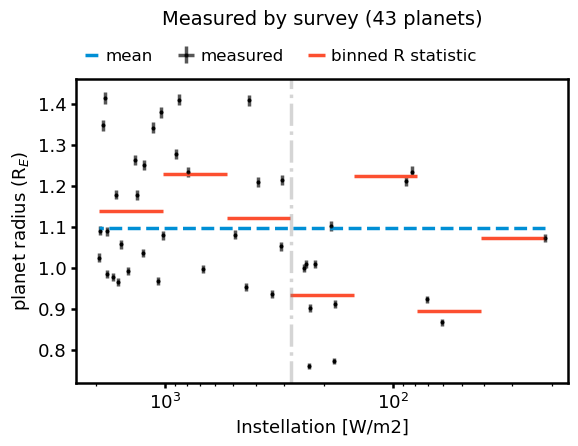

In [22]:
yvar = parameter_of_interest
xvar = 'S_abs'
# yvar = 'R' 

fig, ax = plt.subplots()
ax.scatter(data[xvar], data[yvar], s=2, c='k')
ax.errorbar(data[xvar], data[yvar], xerr=data.error[xvar], yerr=data.error[yvar], fmt='o', ms=2., 
            color='k', alpha=.66, label='measured')


ax.set_xscale('log')
# ax.set_yscale('log')


# plot binned stats as errorbar plot
means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), np.max(data[xvar]), num=8), statistic='mean')
ax.hlines(np.mean(data[yvar]), np.min(data[xvar]), np.max(data[xvar]), color='C2', ls='--', label='mean')
ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
           yerr=None, fmt='none', color='C1', label='binned {} statistic'.format(yvar), elinewidth=2.5)

if xvar == 'S_abs':
    ax.set_xlabel('Instellation [W/m2]')
    ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
    ax.invert_xaxis()

if yvar == 'R':
    ax.set_ylabel('planet radius (R$_E$)')
elif yvar == 'rho':
    ax.set_ylabel('bulk density(g/cm3)')
    
ax.set_title('Measured by survey ({} planets)'.format(N), y=1.15, fontsize=14)
fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.15, .97),
                              frameon=False, columnspacing=1.6)


# Hypothesis tests 

## Define Hypotheses

In [25]:
from bioverse.hypothesis import Hypothesis, magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 

# params = ('f_magma', 'a_cut', 'radius_reduction', 'R_avg')    # for step function
# params = ('f_magma', 'a_cut', 'lambda_a')   # for exp. decay
if parameter_of_interest == 'R':
    params = ('S_thresh', 'wrr', 'avg')
    labels = ('R',)
elif parameter_of_interest == 'rho':
    params = ('S_thresh', 'wrr', 'avg')
    labels = ('rho',)
    
    
labels = (parameter_of_interest + '_mean',)    

    
features = ('a_eff',)

# define priors for the parameters in theta (log-uniform for 'S_thresh' and 'wrr', uniform for 'R_avg')
bounds = np.array([[10., 1000.0], [1e-5, 0.1], [.1, 15.]])
# bounds = np.array([[10., 1000.0], [1e-5, 1.00], [.1, 15.]])


log = (True, True, False)
# log = (True, False, False)
# bounds = np.array([[0.001, 1.0], [0.01, 10.], [0.005, 4.]]) # for exp decay
# log = (False, True, False) # for exp decay



# interpolate average delta R/delta rho
avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 
select_mechanisms = (avg_deltaR_deltaRho.gh_increase == planets_args['gh_increase']) & (
                    avg_deltaR_deltaRho.water_incorp == planets_args['water_incorp'])
f_dR = scipy.interpolate.interp1d(avg_deltaR_deltaRho[select_mechanisms].wrr,
                avg_deltaR_deltaRho[select_mechanisms]['delta_' + parameter_of_interest],
                fill_value='extrapolate')


# define hypothesis; define null hypothesis (a broad distribution in planet radius that is independent of orbital distance)
bounds_null = np.array([bounds[-1]])            # prior bounds for null hypothesis

if parameter_of_interest == 'R':
    h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'], 
                              simplified=planets_args['simplified'], diff_frac=radius_change, parameter_of_interest=parameter_of_interest, f_dR=f_dR)
    # h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(True,))
    h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(log[-1],))
    
    
    
elif parameter_of_interest == 'rho':
    h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                              simplified=planets_args['simplified'], diff_frac=density_change, parameter_of_interest=parameter_of_interest, f_dR=f_dR)
    # h_magmaocean = Hypothesis(magma_ocean_hypo_exp, bounds, params=params, features=features, labels=labels, log=log)
    h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('rho_avg_random',), features=features, labels=labels, log=(log[-1],))

compute rolling mean of radius and its uncertainty

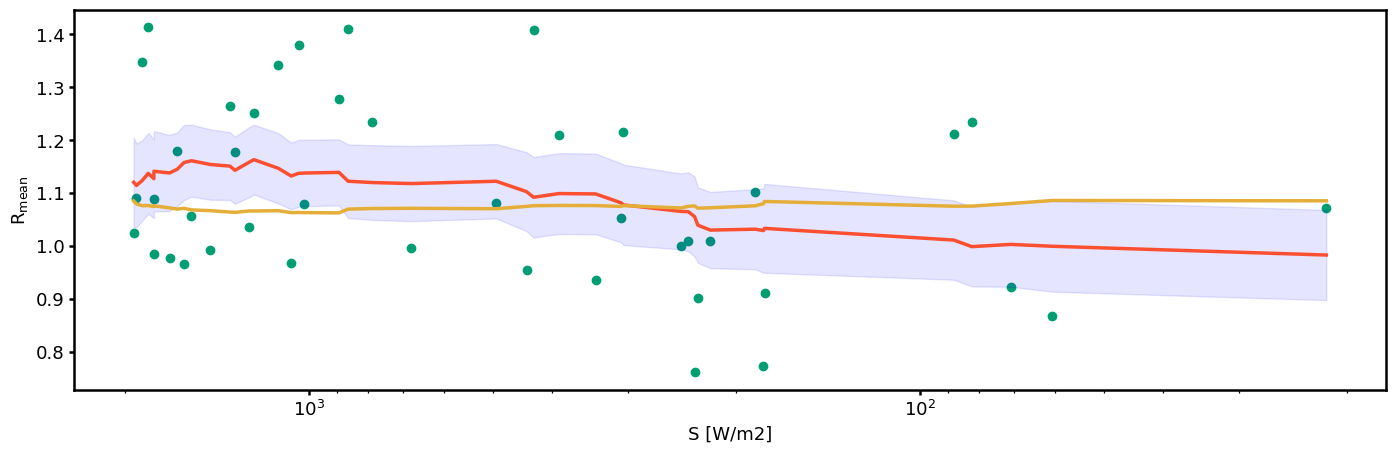

In [26]:
def rolling_mean(d, window):
    dd = d.to_pandas()
    R_mean = dd.sort_values('S_abs')['R'].rolling(window, center=True,min_periods=1).mean()
    R_sem = dd.sort_values('S_abs')['R'].rolling(window, center=True,min_periods=1).sem()  # rolling standard error of mean
    rho_mean = dd.sort_values('S_abs')['rho'].rolling(window, center=True,min_periods=1).mean()
    rho_sem = dd.sort_values('S_abs')['rho'].rolling(window, center=True,min_periods=1).sem()  # rolling standard error of mean

    data.sort_by('S_abs', inplace=True)
    data['R_mean'] = R_mean
    data['rho_mean'] = rho_mean
    # data.error['R_mean'] = 20*data.error['R']
    data.error.sort_by('S_abs', inplace=True)
    data.error['R_mean'] = R_sem
    data.error['rho_mean'] = rho_sem
    return data

def plot_rolling_mean(data, parameter_of_interest='R'):
    """diagnostic plot"""
    fig, ax = plt.subplots(figsize=[16,5])
    ax.scatter(data['S_abs'], data[parameter_of_interest])
    ax.plot(data.sort_by('S_abs')['S_abs'], data.sort_by('S_abs')[parameter_of_interest +'_mean'], c='C1')
    mean = data.sort_by('S_abs')[parameter_of_interest + '_mean']
    sem = data.error.sort_by('S_abs')[parameter_of_interest + '_mean']
    ax.fill_between(data.sort_by('S_abs')['S_abs'], (mean-sem), (mean+sem), color='b', alpha=.1)
    ax.plot(data.sort_by('S_abs')['S_abs'], data.error[parameter_of_interest + '_mean'] + 1, c='C3')
    ax.set_ylabel(parameter_of_interest + '$_\mathrm{mean}$')
    ax.set_xlabel('S [W/m2]')
    ax.invert_xaxis()
    ax.set_xscale('log')

    
data = rolling_mean(data, window=25)
# data = rolling_mean(data, window=3)


# crank up rolling mean errors to account for measurement errors
data.error['R_mean'] *= 2.
data.error['rho_mean'] *= 2.

plot_rolling_mean(data, parameter_of_interest=parameter_of_interest)

## Perform hypothesis testing 

Sample posterior; Calculate the Bayesian evidence supporting h_magmaocean in favor of h_null from our simulated dataset.

The parameter space is complex, need to use nested sampling (not MCMC).

In [27]:
%%time
import corner

nburn = 10
nlive = 200

# Sample the posterior distribution of h(theta | x, y) using a simulated data set, and compare to the null hypothesis via a model comparison metric.
results = h_magmaocean.fit(data, return_chains=True, nburn=nburn, nlive=nlive, sampler_results=True)
# results = h_magmaocean.fit(data, return_chains=True, nburn=100, nlive=200, method='emcee')
 
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
    results['dlnZ'], np.exp(-results['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 5.5 (corresponds to p = 0.004)
CPU times: user 5.2 s, sys: 153 ms, total: 5.36 s
Wall time: 5.7 s


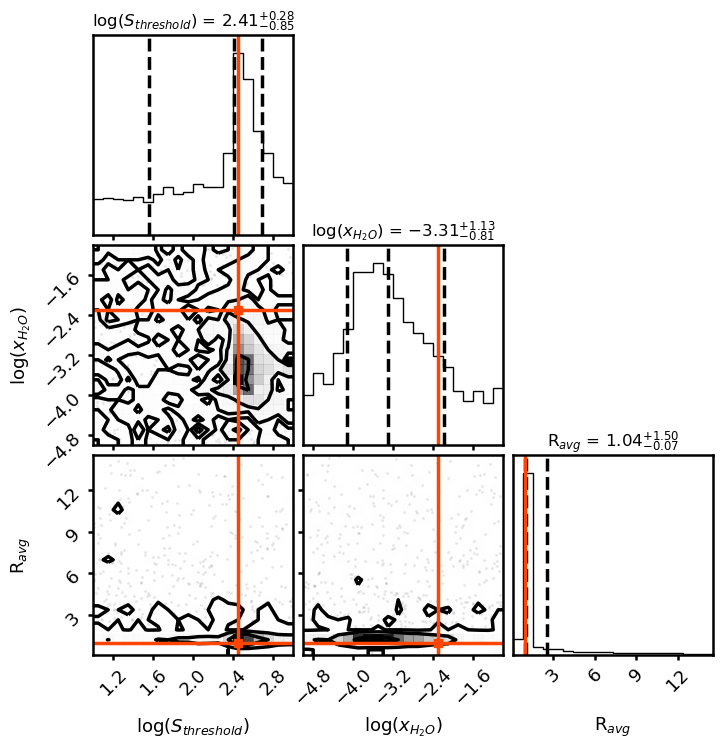

In [28]:
# plt.style.use('classic')sampler_resultsn into DataFrame, make logged columns for params with log priors
chains = pd.DataFrame(results['chains'], columns=params)
for p, l in zip(params, log):
    if l:
        chains['log_' + p] = np.log10(chains[p])
        
        
# compute truths
if parameter_of_interest == 'R':
    avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
elif parameter_of_interest == 'rho':
    avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                         (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
truths=np.array([np.log10(planets_args['S_thresh']), np.log10(planets_args['wrr']), avg_out])

fig = corner.corner(
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$'],
                    # chains[['f_magma', 'log_a_cut', 'lambda_a']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$\lambda_a$'],
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction','R_avg']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$', 'R$_{avg}$'],
                    chains[['log_S_thresh', 'log_wrr', 'avg']], labels=['$\log(S_{threshold})$', '$\log(x_{H_2O})$', parameter_of_interest + '$_{avg}$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12},
                    truths=truths, truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['lambda_a']], truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['radius_reduction'], R_avg], truth_color='orangered'
                    )

fig.set_facecolor('white')

## Sampling diagnostics

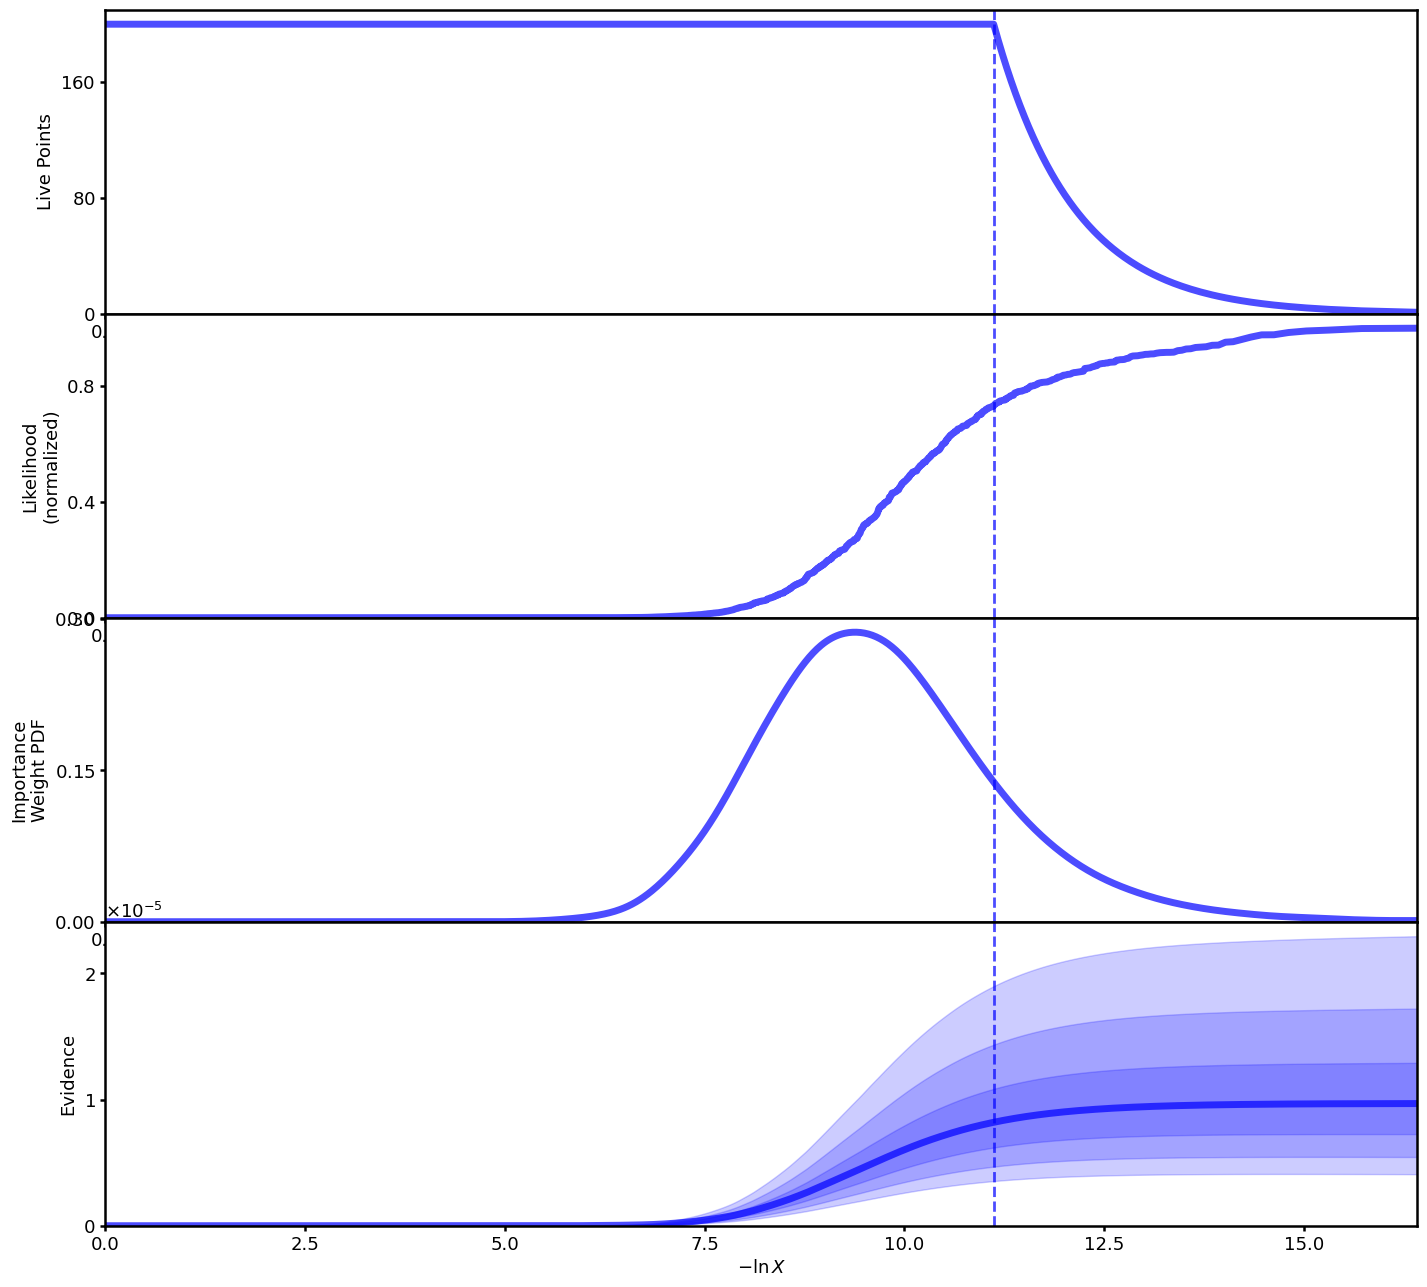

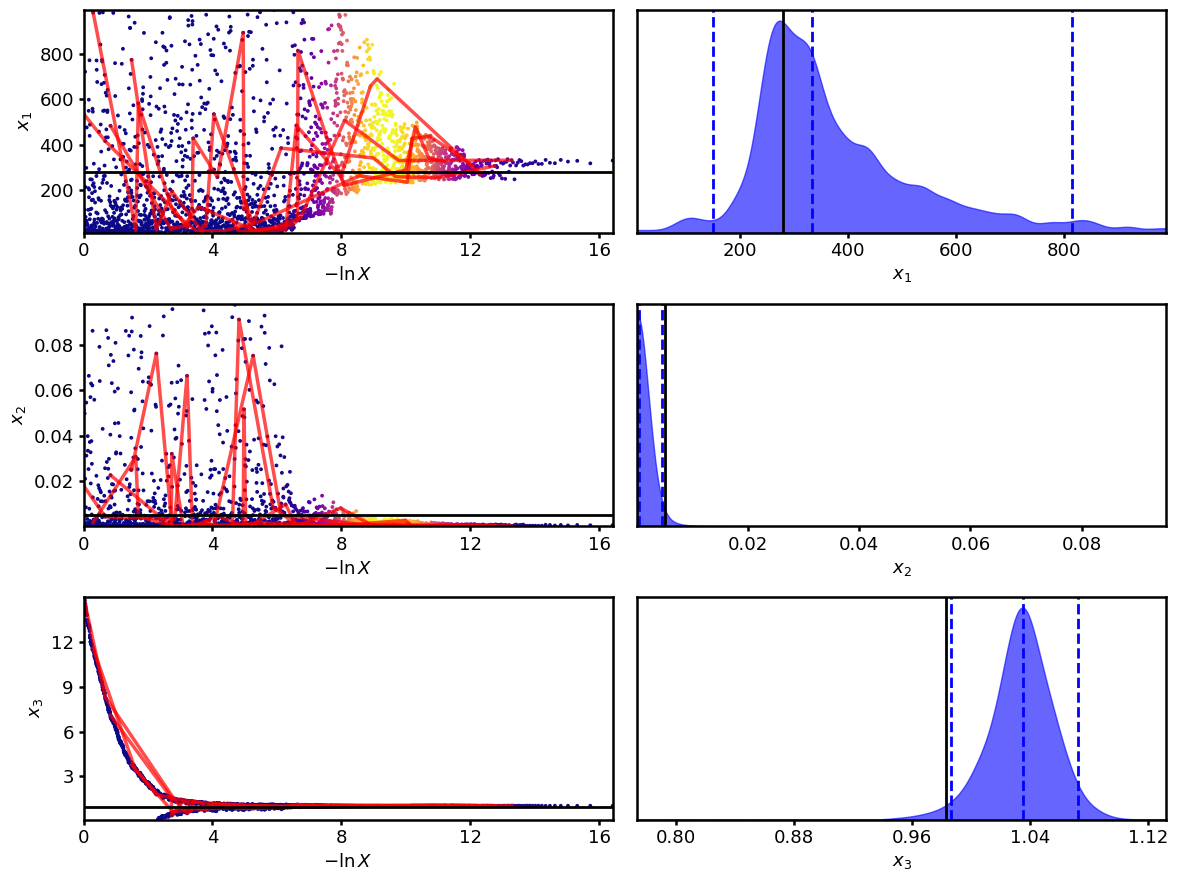

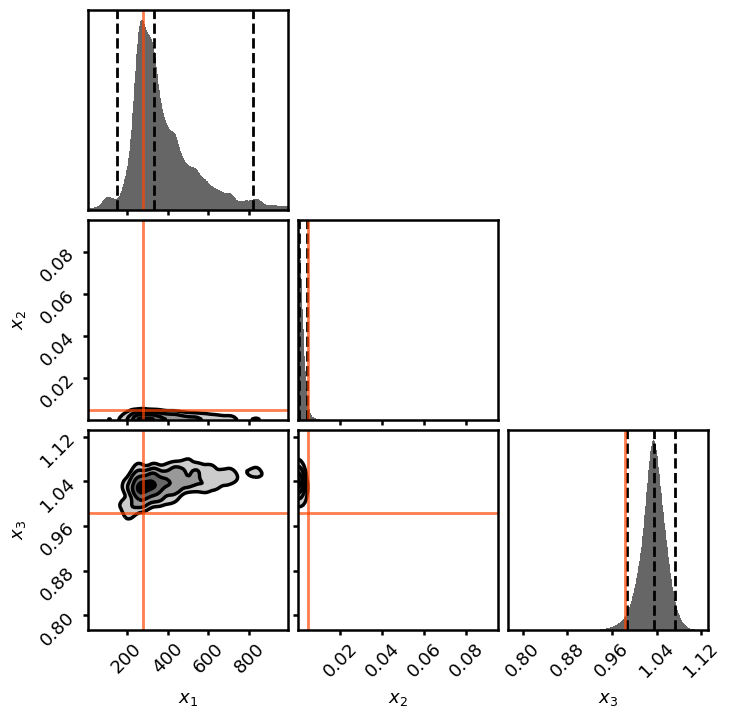

In [29]:
sampler_results = results['sampler_results']
exp_truths = [10**t if l else t for t, l in zip(truths, log)]

from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sampler_results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(sampler_results, truths=exp_truths, truth_color='black', connect=True,
                             connect_highlight=range(5))
plt.tight_layout()

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(sampler_results, truths=exp_truths, truth_color='orangered')

show samples from the posterior

/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


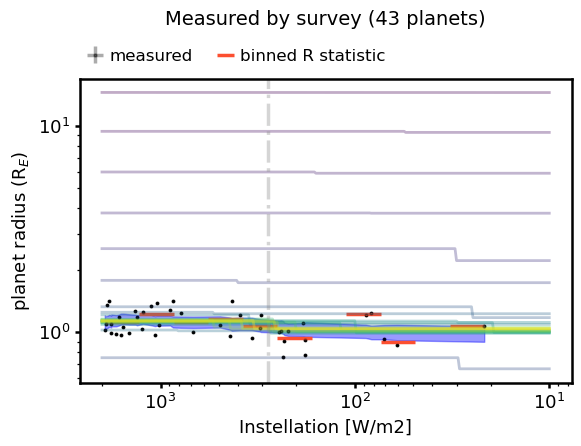

In [30]:
# %matplotlib widget

from bioverse.util import S2a_eff
yvar = parameter_of_interest
xvar = 'S_abs'
# yvar = 'R' 

fig, ax = plt.subplots()
ax.scatter(data[xvar], data[yvar], s=2, c='k')
ax.errorbar(data[xvar], data[yvar], xerr=data.error[xvar], yerr=data.error[yvar], fmt='o', ms=2., 
            color='k', alpha=.33, label='measured')

# overplot samples from the posterior
sampler_results = results['sampler_results']
posterior_sample = sampler_results.samples[nburn::100]

S_grid = np.geomspace(10., 2000., 300)
a_eff_grid = S2a_eff(S_grid)

colors = plt.cm.viridis(np.linspace(0, 1, len(posterior_sample)))
for i, s in enumerate(posterior_sample):
    P_magma = magma_ocean_hypo((s[0], s[1], s[2]), a_eff_grid,
                               gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                               simplified=planets_args['simplified'], parameter_of_interest=parameter_of_interest)
    ax.plot(S_grid, P_magma, c=colors[i],
            alpha=.33, lw=2.)
    
    
# plot binned stats as errorbar plot
means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), np.max(data[xvar]), num=12), statistic='mean')
# ax.hlines(np.mean(data[yvar]), np.min(data[xvar]), np.max(data[xvar]), color='C2', ls='--', label='mean')
ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
           yerr=None, fmt='none', color='C1', label='binned {} statistic'.format(yvar), elinewidth=2.5)

# fig.colorbar()

ax.set_xscale('log')
ax.set_yscale('log')
if xvar == 'S_abs':
    ax.set_xlabel('Instellation [W/m2]')
    ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
    ax.invert_xaxis()
if yvar == 'R':
    ax.set_ylabel('planet radius (R$_E$)')
elif yvar == 'rho':
    ax.set_ylabel('bulk density(g/cm3)')
    
    
# add confidence interval of rolling mean radius
mean = data.sort_by('S_abs')[parameter_of_interest + '_mean']
sem = data.error.sort_by('S_abs')[parameter_of_interest + '_mean']
ax.fill_between(data.sort_by('S_abs')['S_abs'], (mean-sem), (mean+sem), color='b', alpha=.4)


ax.set_title('Measured by survey ({} planets)'.format(N), y=1.15, fontsize=14)
fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.15, .97),
                              frameon=False, columnspacing=1.6)

# ax.axhline(0.98, color='C2', ls='--', label='mean')

# ax.set_xlim(50., 1000)
# ax.set_ylim(0.8, 1.5)
# ax.set_ylim(1.8, 5.)

# Statistical Power
Test sensitivity on Poisson uncertainty, e.g. the specific realization of a survey.

In [31]:
%%time

from bioverse import analysis

# Repeat the hypothesis test for different magma ocean parameter values
# S_thresh_grid = np.linspace(10, 1500, 6)
# wrr_grid = [0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# wrr_grid = [0., 0.0001, 0.01, 0.05]
d_grid = np.round(np.geomspace(30, 70, 8))

# results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, S_thresh=S_thresh_grid, N=10, processes=8)
# results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, N=10, processes=8)
results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, d_max=d_grid, N=20, processes=8, **planets_args)

# Determine the statistical power assuming a significance threshold of dlnZ > 3
# power = analysis.compute_statistical_power(results, method='dlnZ', threshold=3)
# print("The statistical power of the survey is {:.1f}%".format(100*power))

  0%|                                                                                                                                                                                            | 0/160 [00:16<?, ?it/s]


Interrupted, terminating remaining processes
CPU times: user 46.8 ms, sys: 116 ms, total: 162 ms
Wall time: 17.1 s



multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/schlecker/repos/Bioverse/bioverse/analysis.py", line 109, in test_hypothesis_grid_iter
    results = h.fit(data, return_chains=return_chains, method=method, nlive=nlive, mw_alternative=mw_alternative)
  File "/Users/schlecker/repos/Bioverse/bioverse/hypothesis.py", line 255, in fit
    X, Y, sigma = self.get_XY(data)
  File "/Users/schlecker/repos/Bioverse/bioverse/hypothesis.py", line 194, in get_XY
    data.compute(key)
  File "/Users/schlecker/repos/Bioverse/bioverse/classes.py", line 312, in compute
    raise ValueError("no formula defined for {:s}".format(key))
ValueError: no formula defined for R_mean
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/schlecker/repos/Bioverse/b

In [32]:
# plt.plot(S_thresh_grid, results['dlnZ'].mean(axis=-1), lw=5)
# plt.plot(wrr_grid, results['dlnZ'].mean(axis=-1), lw=5)
# plt.plot(d_grid, results['dlnZ'].mean(axis=-1), lw=5)
plt.plot(results['N_pl'][:,0], results['dlnZ'].mean(axis=-1), lw=3)

percentiles = np.percentile(results['dlnZ'], [5., 95.], axis=1)    # 5% and 95% percentiles

lns2 = plt.fill_between(results['N_pl'][:,0],
                     percentiles[0],
                     percentiles[1],
                     color=(0.45, 0.65, 0.9), alpha=.5,
                     label="90\% prediction interval")

# plt.xlabel('S_thresh', fontsize=20)
# plt.xlabel('water fraction', fontsize=20)
# plt.xlabel('d_max', fontsize=20)
plt.xlabel('Planet yield $N_\mathrm{detections}$', fontsize=20)

plt.ylabel('$\Delta$lnZ', fontsize=20)
plt.axhline(3, lw=5, c='black', linestyle='dashed')
plt.xscale('log')
# plt.yscale('log')
# plt.xlim(right=500)


# plt.loglog()


KeyError: 'N_pl'